# 📚 GIẢI THÍCH CÁC THUẬT TOÁN SỬ DỤNG

## 🎯 Tổng Quan Workflow

Notebook này sử dụng **4 thuật toán Machine Learning** chính và **3 phương pháp đánh giá**:

### 🤖 CÁC THUẬT TOÁN HỌC MÁY

| Thuật Toán | Loại | Độ Phức Tạp | Khi Nào Dùng |
|------------|------|-------------|--------------|
| **Linear Regression** | Simple | Thấp | Baseline, dữ liệu tuyến tính |
| **Random Forest** | Ensemble (Bagging) | Trung bình | Robust, dữ liệu phức tạp |
| **XGBoost** | Ensemble (Boosting) | Cao | Highest accuracy |
| **LightGBM** | Ensemble (Boosting) | Cao | Large data, speed |

### 📊 PHƯƠNG PHÁP ĐÁNH GIÁ

1. **Train-Test Split (80/20)**: Chia data để đánh giá khách quan
2. **K-Fold Cross-Validation**: Đánh giá robust với K=5 folds  
3. **Hyperparameter Tuning**: Tối ưu parameters bằng Grid Search

### 📈 CÁC METRICS

- **MAE** (Mean Absolute Error): Sai số trung bình (VNĐ)
- **RMSE** (Root Mean Squared Error): Sai số RMS, penalize outliers
- **R² Score**: % variance được giải thích (0-1, càng cao càng tốt)
- **MAPE** (Mean Absolute Percentage Error): Sai số % (dễ hiểu)

---

**💡 Lưu ý**: Tất cả thuật toán đều có **comment chi tiết** trong các cell bên dưới!

# Dự Đoán Giá Nhà Việt Nam - Huấn Luyện Mô Hình

Notebook này trình bày quy trình huấn luyện và đánh giá mô hình dự đoán giá nhà.

## Các bước:
1. Tải dữ liệu đã xử lý
2. Kỹ thuật đặc trưng
3. Huấn luyện nhiều mô hình
4. So sánh mô hình
5. Tinh chỉnh siêu tham số
6. Đánh giá cuối cùng
7. Lưu mô hình tốt nhất

## 1. Import Thư Viện

In [1]:
# Import các thư viện cần thiết
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Thêm thư mục src vào đường dẫn
sys.path.append('../src')

# Import các module tự tạo
from model import HousingPriceModel
from preprocessing import HousingDataPreprocessor
import utils

# Cài đặt style cho biểu đồ
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Đã import thư viện thành công")

✓ Đã import thư viện thành công


## 2. Tải và Chuẩn Bị Dữ Liệu

In [2]:
# Tải dữ liệu đã xử lý
data_path = '../data/processed_housing_data.csv'

try:
    df = pd.read_csv(data_path)
    print(f"✓ Đã tải dữ liệu đã xử lý: {df.shape}")
except FileNotFoundError:
    print("⚠️ Không tìm thấy dữ liệu đã xử lý. Đang tạo dữ liệu mẫu...")
    
    # Tạo dữ liệu mẫu
    np.random.seed(42)
    n_samples = 1000
    
    sample_data = {
        'Quận': np.random.choice(['Ba Đình', 'Hoàn Kiếm', 'Đống Đa', 'Hai Bà Trưng', 
                                  'Cầu Giấy', 'Thanh Xuân'], n_samples),
        'Huyện': np.random.choice(['Ba Đình', 'Hoàn Kiếm', 'Đống Đa'], n_samples),
        'Giá': np.random.uniform(2e9, 15e9, n_samples),
        'Diện tích': np.random.uniform(40, 150, n_samples),
        'Giá/m²': np.random.uniform(30e6, 120e6, n_samples),
        'Số tầng': np.random.randint(1, 5, n_samples),
        'Số phòng ngủ': np.random.randint(2, 5, n_samples),
        'Dài': np.random.uniform(5, 15, n_samples),
        'Rộng': np.random.uniform(4, 12, n_samples),
        'Loại hình nhà ở': np.random.choice(['Nhà riêng', 'Nhà mặt phố', 'Biệt thự'], n_samples),
        'Giấy tờ pháp lý': np.random.choice(['Sổ đỏ/ Sổ hồng', 'Hợp đồng mua bán'], n_samples)
    }
    
    df = pd.DataFrame(sample_data)
    print(f"✓ Đã tạo dữ liệu mẫu: {df.shape}")

# Hiển thị thông tin dữ liệu
print("\nThông Tin Dữ Liệu:")
df.info()

✓ Đã tải dữ liệu đã xử lý: (1000, 13)

Thông Tin Dữ Liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ngày             1000 non-null   object 
 1   Địa chỉ          1000 non-null   object 
 2   Quận             1000 non-null   object 
 3   Huyện            1000 non-null   object 
 4   Giá              1000 non-null   float64
 5   Diện tích        1000 non-null   float64
 6   Giá/m²           1000 non-null   float64
 7   Số tầng          1000 non-null   float64
 8   Số phòng ngủ     1000 non-null   int64  
 9   Dài              1000 non-null   float64
 10  Rộng             1000 non-null   float64
 11  Loại hình nhà ở  1000 non-null   object 
 12  Giấy tờ pháp lý  1000 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 101.7+ KB


## 3. Kỹ Thuật Đặc Trưng

In [3]:
# ============================================================================
# THUẬT TOÁN: LABEL ENCODING (Mã Hóa Nhãn)
# ============================================================================
#
# MỤC ĐÍCH:
# Machine Learning models chỉ làm việc với số, không thể process text/strings
# → Cần chuyển đổi categorical variables (text) thành numerical values
#
# CÁCH HOẠT ĐỘNG:
# Label Encoding gán mỗi unique category một số nguyên duy nhất
#
# VÍ DỤ:
# Original:          Encoded:
# 'Ba Đình'     →    0
# 'Hoàn Kiếm'   →    1  
# 'Đống Đa'     →    2
# 'Ba Đình'     →    0  (giống nhau → cùng số)
# 'Cầu Giấy'    →    3
#
# QUY TRÌNH:
# 1. Identify unique categories: ['Ba Đình', 'Hoàn Kiếm', 'Đống Đa', ...]
# 2. Sort alphabetically (optional, for consistency)
# 3. Assign integers: 0, 1, 2, 3, ...
# 4. Create mapping dictionary: {'Ba Đình': 0, 'Hoàn Kiếm': 1, ...}
# 5. Transform data using mapping
#
# ƯU ĐIỂM:
# - Đơn giản và nhanh
# - Tiết kiệm bộ nhớ (chỉ dùng 1 column thay vì nhiều columns)
# - Phù hợp với tree-based models (Random Forest, XGBoost, LightGBM)
# - Giữ được cardinality (số lượng unique values)
#
# NHƯỢC ĐIỂM:
# - Tạo "ordinal relationship" giả (implies thứ tự)
#   Ví dụ: 0 < 1 < 2 → model có thể nghĩ 'Đống Đa' > 'Ba Đình'
#   Nhưng thực tế không có relationship này!
# - Không tốt cho Linear Regression (vì assumes linear relationship)
# - Distance between categories không có ý nghĩa
#   Ví dụ: Distance(0,1) = Distance(1,2) nhưng districts không equal spacing
#
# ALTERNATIVE: ONE-HOT ENCODING
# One-hot tạo binary column cho mỗi category:
# 'Ba Đình'    → [1, 0, 0, 0]
# 'Hoàn Kiếm'  → [0, 1, 0, 0]
# 'Đống Đa'    → [0, 0, 1, 0]
# 
# Ưu điểm: Không tạo ordinal relationship
# Nhược điểm: Tạo nhiều columns (curse of dimensionality)
#
# TRONG PROJECT NÀY:
# - Dùng Label Encoding vì:
#   1. Sử dụng tree-based models (RF, XGB, LGBM) - OK với label encoding
#   2. Nhiều categorical features với high cardinality
#   3. One-hot sẽ tạo quá nhiều columns
# ============================================================================

# Mã hóa các biến phân loại
preprocessor = HousingDataPreprocessor()
preprocessor.df = df.copy()

# Áp dụng Label Encoding cho tất cả categorical columns
df_encoded = preprocessor.encode_categorical()

print("\nDữ Liệu Sau Khi Mã Hóa:")
print(df_encoded.head())

print("\n💡 LƯU Ý:")
print("  • Categorical columns (text) đã được chuyển thành số")
print("  • Mỗi category có một số nguyên duy nhất")
print("  • Mapping được lưu để decode predictions sau này")
print("  • Tree-based models handle label encoding tốt!")

Encoding categorical variables...
  - Encoded 'Quận' (7 unique values)
  - Encoded 'Huyện' (4 unique values)
  - Encoded 'Loại hình nhà ở' (4 unique values)
  - Encoded 'Giấy tờ pháp lý' (2 unique values)
✓ Categorical encoding completed

Dữ Liệu Sau Khi Mã Hóa:
         Ngày    Địa chỉ  Quận  Huyện           Giá   Diện tích        Giá/m²  \
0  2023-01-01  Address 0     5      3  1.339605e+09  179.231113  5.524251e+07   
1  2023-01-02  Address 1     2      2  1.976673e+10  179.528915  9.769688e+07   
2  2023-01-03  Address 2     1      3  9.127690e+09  177.998332  1.325924e+08   
3  2023-01-04  Address 3     5      0  8.302206e+09   70.595356  1.430754e+08   
4  2023-01-05  Address 4     6      0  1.391330e+10  106.710689  3.376775e+07   

   Số tầng  Số phòng ngủ        Dài       Rộng  Loại hình nhà ở  \
0      2.0             4   5.287518   3.499728                0   
1      1.0             2  11.479841  12.967629                1   
2      2.0             1   5.495179   9.855996   

## 4. Chuẩn Bị Tập Huấn Luyện và Kiểm Tra

In [4]:
# ============================================================================
# THUẬT TOÁN: TRAIN-TEST SPLIT
# ============================================================================
#
# MỤC ĐÍCH:
# Chia dữ liệu thành 2 phần riêng biệt để đảm bảo đánh giá khách quan
#
# NGUYÊN LÝ:
# - TRAINING SET (80%): Dùng để train model, model "học" từ dữ liệu này
# - TEST SET (20%): Dùng để đánh giá, model CHƯA BAO GIỜ THẤY dữ liệu này
#
# TẠI SAO CẦN SPLIT?
# Nếu evaluate trên training data → Model sẽ có performance cao giả tạo
# (vì nó đã "thuộc lòng" data này - overfitting)
# Test set giúp đánh giá model trên "unseen data" → Performance thực tế
#
# QUY TRÌNH:
# 1. Shuffle data ngẫu nhiên (đảm bảo random_state cho reproducibility)
# 2. Split: 80% đầu → train, 20% cuối → test
# 3. Train chỉ dùng training set
# 4. Evaluate trên test set
#
# TỶ LỆ PHỔ BIẾN:
# - 80/20: Standard, phù hợp với most datasets
# - 70/30: Khi muốn test set lớn hơn
# - 90/10: Khi có ít data và cần maximize training samples
# 
# RANDOM_STATE:
# - Đảm bảo split giống nhau mỗi lần chạy (reproducibility)
# - Quan trọng cho debugging và comparison
# ============================================================================

# Khởi tạo bộ huấn luyện mô hình
model_trainer = HousingPriceModel(random_state=42)

# Chuẩn bị dữ liệu: Split thành train/test
X_train, X_test, y_train, y_test = model_trainer.prepare_data(
    df_encoded,
    target_col='Giá',
    test_size=0.2  # 20% for testing, 80% for training
)

print("\nTóm Tắt Phân Chia Dữ Liệu:")
print(f"Số mẫu huấn luyện: {len(X_train)}")
print(f"Số mẫu kiểm tra: {len(X_test)}")
print(f"Số đặc trưng: {X_train.shape[1]}")
print(f"\nTỷ lệ: {len(X_train)/len(df_encoded)*100:.1f}% train, "
      f"{len(X_test)/len(df_encoded)*100:.1f}% test")

✓ Data prepared:
  - Training set: 800 samples
  - Test set: 200 samples
  - Features: 10

Tóm Tắt Phân Chia Dữ Liệu:
Số mẫu huấn luyện: 800
Số mẫu kiểm tra: 200
Số đặc trưng: 10

Tỷ lệ: 80.0% train, 20.0% test


## 5. Khởi Tạo Mô Hình

In [5]:
# ============================================================================
# KHỞI TẠO 4 MÔ HÌNH MACHINE LEARNING
# ============================================================================

models = model_trainer.initialize_models()

print("\nCác Mô Hình Đã Khởi Tạo:")
for name, model in models.items():
    print(f"  - {name}: {type(model).__name__}")

# ----------------------------------------------------------------------------
# GIẢI THÍCH CÁC THUẬT TOÁN:
# ----------------------------------------------------------------------------
#
# 1. LINEAR REGRESSION (Hồi Quy Tuyến Tính)
#    - Công thức: y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ
#    - Phương pháp: Ordinary Least Squares (OLS) - minimize sum of squared errors
#    - Ưu điểm: Đơn giản, nhanh, dễ interpret, ít overfitting
#    - Nhược điểm: Chỉ capture linear relationships, kém với dữ liệu phức tạp
#    - Sử dụng: Baseline model, dữ liệu có quan hệ tuyến tính
#
# 2. RANDOM FOREST (Rừng Ngẫu Nhiên)
#    - Cách hoạt động: 
#      + Bootstrap: Tạo n subsets ngẫu nhiên từ training data
#      + Build: Train một decision tree trên mỗi subset
#      + Random features: Mỗi split chỉ xét random subset of features  
#      + Aggregate: Average predictions từ tất cả trees
#    - Hyperparameters:
#      + n_estimators=100: Số lượng trees
#      + max_depth=20: Độ sâu tối đa của mỗi tree
#      + min_samples_split=5: Số mẫu tối thiểu để split node
#      + min_samples_leaf=2: Số mẫu tối thiểu ở leaf
#    - Ưu điểm: Robust, handle non-linear, giảm overfitting, feature importance
#    - Nhược điểm: Chậm, model size lớn, khó interpret
#    - Sử dụng: Dữ liệu phức tạp, cần accuracy cao
#
# 3. XGBOOST (Extreme Gradient Boosting)
#    - Cách hoạt động:
#      + Sequential: Build trees tuần tự, mỗi tree sửa lỗi của tree trước
#      + Gradient: Sử dụng gradient descent để optimize loss function
#      + Regularization: L1 và L2 để prevent overfitting
#      + Formula: F(x) = F₀(x) + η×h₁(x) + η×h₂(x) + ... (η = learning rate)
#    - Hyperparameters:
#      + n_estimators=100: Số boosting rounds
#      + max_depth=7: Độ sâu trees (thường nhỏ hơn Random Forest)
#      + learning_rate=0.1: Tốc độ học (shrinkage)
#    - Ưu điểm: Accuracy rất cao, regularization built-in, handle missing values
#    - Nhược điểm: Dễ overfit, nhiều hyperparameters, cần tune cẩn thận
#    - Sử dụng: Khi cần highest accuracy, có thời gian tune parameters
#
# 4. LIGHTGBM (Light Gradient Boosting Machine)  
#    - Cách hoạt động:
#      + GOSS: Gradient-based One-Side Sampling (giảm data size)
#      + EFB: Exclusive Feature Bundling (giảm feature dimension)
#      + Leaf-wise: Grow tree theo leaf có max loss reduction (vs level-wise)
#    - Hyperparameters:
#      + n_estimators=100: Số iterations
#      + max_depth=7: Độ sâu tối đa
#      + learning_rate=0.1: Tốc độ học
#    - Ưu điểm: RẤT NHANH (2-10x faster than XGBoost), memory efficient
#    - Nhược điểm: Dễ overfit với small dataset (< 10K samples)
#    - Sử dụng: Large datasets, cần training speed, limited memory
#
# CHIẾN LƯỢC LỰA CHỌN:
# - Linear Regression: Baseline để so sánh
# - Random Forest: Ensemble mạnh, ít cần tune
# - XGBoost: Best accuracy khi tune tốt
# - LightGBM: Best speed với large data
# ============================================================================

✓ Initialized 4 models:
  - Linear Regression
  - Random Forest
  - XGBoost
  - LightGBM

Các Mô Hình Đã Khởi Tạo:
  - Linear Regression: LinearRegression
  - Random Forest: RandomForestRegressor
  - XGBoost: XGBRegressor
  - LightGBM: LGBMRegressor


## 6. Huấn Luyện Tất Cả Mô Hình

In [6]:
# Huấn luyện và đánh giá tất cả các mô hình
results = model_trainer.train_all_models(evaluate=True)


TRAINING ALL MODELS

Training Linear Regression...
✓ Linear Regression training completed

Linear Regression Results:
  MAE:  4,877,601,220.75 VNĐ
  RMSE: 5,684,928,532.79 VNĐ
  R²:   -0.0178
  MAPE: 102.30%
Training Random Forest...
✓ Random Forest training completed

Random Forest Results:
  MAE:  4,940,841,167.41 VNĐ
  RMSE: 5,790,693,384.62 VNĐ
  R²:   -0.0560
  MAPE: 101.90%
Training XGBoost...
✓ XGBoost training completed

XGBoost Results:
  MAE:  5,167,386,498.66 VNĐ
  RMSE: 6,251,049,098.36 VNĐ
  R²:   -0.2306
  MAPE: 105.77%
Training LightGBM...
✓ LightGBM training completed

LightGBM Results:
  MAE:  4,978,554,897.60 VNĐ
  RMSE: 5,945,575,445.74 VNĐ
  R²:   -0.1133
  MAPE: 97.49%

BEST MODEL: Linear Regression



## 7. So Sánh Mô Hình

In [7]:
# Tạo bảng so sánh kết quả
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R2', ascending=False)

print("\nSo Sánh Các Mô Hình:")
print(results_df)

# Định dạng để hiển thị chi tiết hơn
print("\n" + "="*80)
print("KẾT QUẢ CHI TIẾT")
print("="*80)
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    utils.print_metrics(metrics, title="")


So Sánh Các Mô Hình:
                            MAE          RMSE        R2        MAPE
Linear Regression  4.877601e+09  5.684929e+09 -0.017791  102.297383
Random Forest      4.940841e+09  5.790693e+09 -0.056014  101.898582
LightGBM           4.978555e+09  5.945575e+09 -0.113259   97.489737
XGBoost            5.167386e+09  6.251049e+09 -0.230593  105.770684

KẾT QUẢ CHI TIẾT

Linear Regression:

                                                            
MAE...................... 4,877,601,221 VNĐ
RMSE..................... 5,684,928,533 VNĐ
R2....................... -0.0178
MAPE..................... 102.30%


Random Forest:

                                                            
MAE...................... 4,940,841,167 VNĐ
RMSE..................... 5,790,693,385 VNĐ
R2....................... -0.0560
MAPE..................... 101.90%


XGBoost:

                                                            
MAE...................... 5,167,386,499 VNĐ
RMSE..................... 6,25

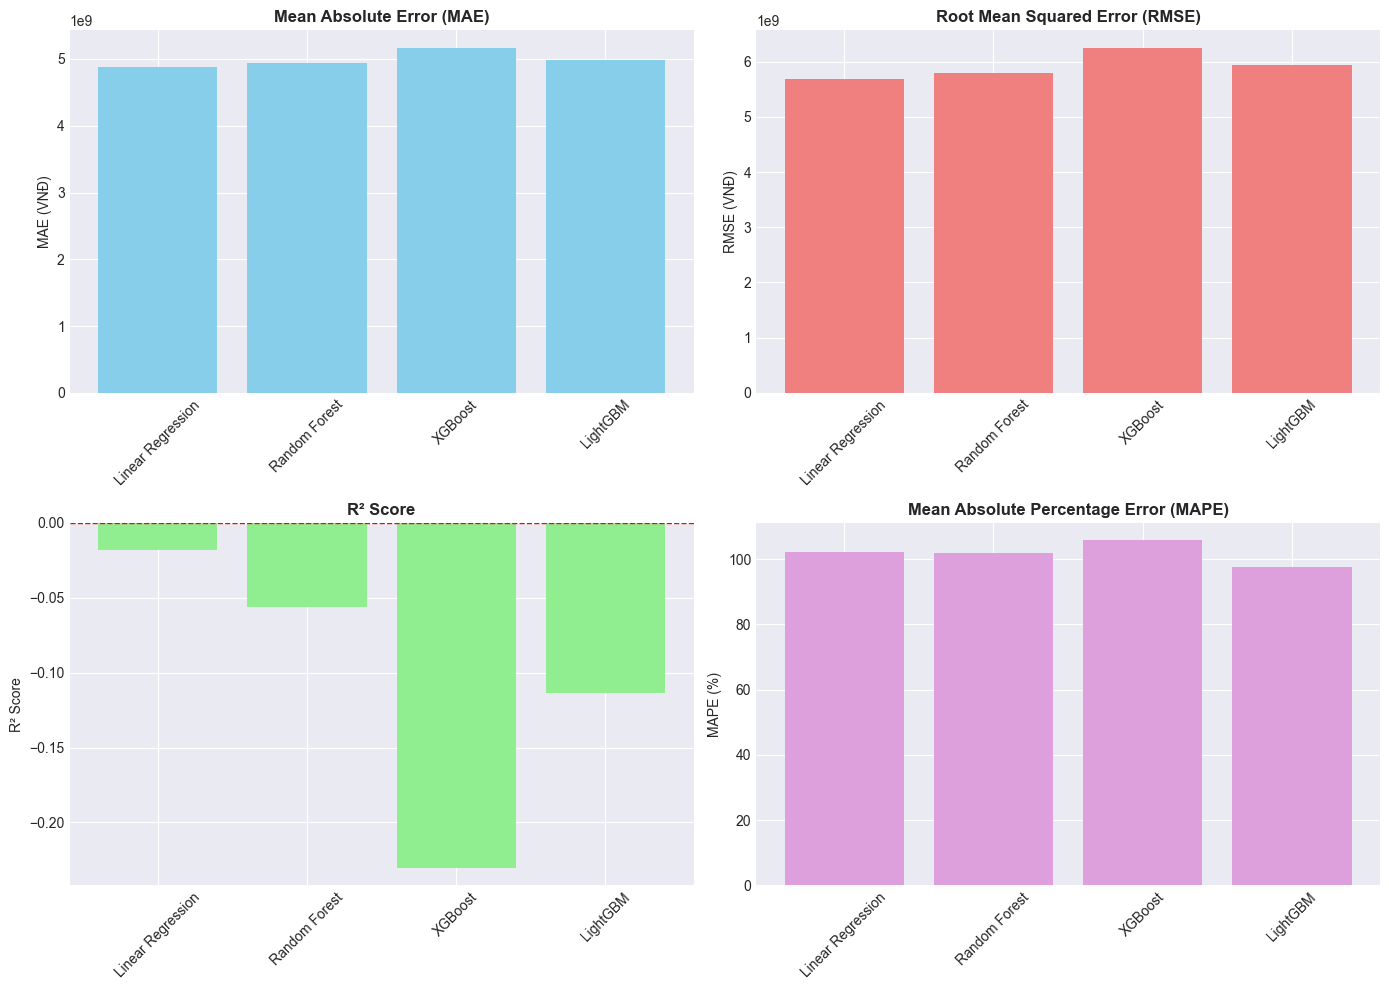

In [8]:
# Trực quan hóa kết quả
model_trainer.plot_results(figsize=(14, 10))

## 8. Kiểm Chứng Chéo (Cross-Validation)

In [9]:
# ============================================================================
# THUẬT TOÁN: K-FOLD CROSS-VALIDATION (KIỂM CHỨNG CHÉO)
# ============================================================================
#
# MỤC ĐÍCH:
# Cross-validation cung cấp đánh giá robust hơn train-test split đơn giản
# vì nó sử dụng toàn bộ data cho cả training và validation
#
# CÁCH HOẠT ĐỘNG (với cv=5):
# 
# Iteration 1: [Test][Train][Train][Train][Train] → Score 1
# Iteration 2: [Train][Test][Train][Train][Train] → Score 2  
# Iteration 3: [Train][Train][Test][Train][Train] → Score 3
# Iteration 4: [Train][Train][Train][Test][Train] → Score 4
# Iteration 5: [Train][Train][Train][Train][Test] → Score 5
# 
# Final Score = Mean(Score 1, 2, 3, 4, 5) ± Std
#
# QUY TRÌNH CHI TIẾT:
# 1. Chia training data thành K folds (thường K=5 hoặc 10)
# 2. Với mỗi iteration k=1..K:
#    a. Fold thứ k làm validation set
#    b. K-1 folds còn lại làm training set
#    c. Train model trên training set
#    d. Evaluate trên validation set → score_k
# 3. Tính mean và std của K scores
# 4. Final Score = mean ± std
#
# ƯU ĐIỂM:
# - Sử dụng 100% data cho cả training và validation
# - Đánh giá robust và reliable hơn single split
# - Detect overfitting tốt hơn (nếu train score >> CV score)
# - Giảm variance trong evaluation metrics
#
# NHƯỢC ĐIỂM:
# - Training chậm hơn K lần (với K=5 thì train 5 models)
# - Không phù hợp với very large datasets (quá chậm)
#
# SCORING METRIC:
# - neg_mean_absolute_error: Sklearn dùng negative vì nó maximize scores
#   Score càng cao càng tốt, nên MAE được convert thành -MAE
#   Sau khi có scores, ta convert lại: MAE = -score
# ============================================================================

print("Đang thực hiện kiểm chứng chéo...\n")

cv_results = {}
for model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
    if model_name in model_trainer.models:
        print(f"\n{model_name}:")
        # Thực hiện 5-fold CV trên từng model
        cv_result = model_trainer.cross_validate_model(model_name, cv=5)
        cv_results[model_name] = cv_result

# Hiển thị kết quả kiểm chứng chéo
print("\n" + "="*60)
print("TÓM TẮT KIỂM CHỨNG CHÉO")
print("="*60)
for model_name, result in cv_results.items():
    # Format: Mean Score ± Standard Deviation
    # Std cao → Model không stable (performance khác nhau nhiều giữa các folds)
    # Std thấp → Model stable và reliable
    print(f"{model_name}: {result['mean_score']:.2f} (+/- {result['std_score']:.2f})")

Đang thực hiện kiểm chứng chéo...


Random Forest:
Cross-validating Random Forest with 5 folds...
✓ CV Score: 4881389422.02 (+/- 123325966.29)

XGBoost:
Cross-validating XGBoost with 5 folds...
✓ CV Score: 5013516094.07 (+/- 144804204.49)

LightGBM:
Cross-validating LightGBM with 5 folds...
✓ CV Score: 5079433176.46 (+/- 142590125.89)

TÓM TẮT KIỂM CHỨNG CHÉO
Random Forest: 4881389422.02 (+/- 123325966.29)
XGBoost: 5013516094.07 (+/- 144804204.49)
LightGBM: 5079433176.46 (+/- 142590125.89)


## 9. Độ Quan Trọng Của Đặc Trưng

In [10]:
# ============================================================================
# PHÂN TÍCH FEATURE IMPORTANCE (ĐỘ QUAN TRỌNG CỦA ĐẶC TRƯNG)
# ============================================================================
#
# MỤC ĐÍCH:
# Hiểu đặc trưng nào ảnh hưởng nhiều nhất đến predictions của model
#
# CÁCH TÍNH (cho Tree-based models):
#
# 1. RANDOM FOREST & DECISION TREES:
#    - Dựa trên "Mean Decrease in Impurity" (MDI)
#    - Mỗi lần feature được dùng để split node:
#      + Tính decrease in impurity (Gini or MSE)
#      + Accumulate cho feature đó
#    - Importance = Total decrease / Total nodes
#    - Normalize về [0, 1]
#
# 2. XGBOOST & LIGHTGBM:
#    - Có nhiều types:
#      + 'gain': Total gain của splits using this feature (default)
#      + 'weight': Số lần feature được dùng để split
#      + 'cover': Number of observations affected by splits
#    - Gain importance phổ biến nhất vì reflect actual contribution
#
# VÍ DỤ GIẢI THÍCH:
# Nếu 'Diện tích' có importance = 0.35 (35%):
# → 35% decisions của model dựa vào feature này
# → Feature này giải thích 35% predictive power của model
#
# SỬ DỤNG:
# 1. Feature Selection: Remove low-importance features
# 2. Business Insights: Hiểu factors nào quan trọng (ví dụ: location vs size)
# 3. Model Simplification: Giữ top-N features, remove rest
# 4. Data Collection: Focus resources vào important features
#
# LƯU Ý:
# - Feature importance CÓ THỂ MISLEAD với:
#   + Correlated features: Importance split giữa các features tương quan
#   + High cardinality: Features với nhiều unique values có bias cao
# - Nên kết hợp với domain knowledge
# ============================================================================

# Lấy độ quan trọng của đặc trưng từ mô hình tốt nhất
best_model_name = model_trainer.best_model_name
print(f"Mô Hình Tốt Nhất: {best_model_name}\n")

# Hiển thị top 15 features quan trọng nhất
importance_df = model_trainer.get_feature_importance(top_n=15)
print("15 Đặc Trưng Quan Trọng Nhất:")
print(importance_df)

print("\n💡 CÁCH ĐỌC KẾT QUẢ:")
print("  • Importance scores được normalize về tổng = 1.0 (hoặc 100%)")
print("  • Feature ở top có ảnh hưởng lớn nhất đến predictions")
print("  • Có thể remove features có importance < 0.01 (1%) để simplify model")

# Vẽ biểu đồ độ quan trọng của đặc trưng
model_trainer.plot_feature_importance(top_n=15)

Mô Hình Tốt Nhất: Linear Regression

Linear Regression does not support feature importance
15 Đặc Trưng Quan Trọng Nhất:
Empty DataFrame
Columns: []
Index: []

💡 CÁCH ĐỌC KẾT QUẢ:
  • Importance scores được normalize về tổng = 1.0 (hoặc 100%)
  • Feature ở top có ảnh hưởng lớn nhất đến predictions
  • Có thể remove features có importance < 0.01 (1%) để simplify model
Linear Regression does not support feature importance


## 10. Tinh Chỉnh Siêu Tham Số (Tùy Chọn)

In [11]:
# ============================================================================
# THUẬT TOÁN: HYPERPARAMETER TUNING - GRID SEARCH
# ============================================================================
#
# MỤC ĐÍCH:
# Tìm tổ hợp hyperparameters tối ưu cho model để maximize performance
#
# CÁCH HOẠT ĐỘNG:
#
# 1. ĐỊNH NGHĨA PARAMETER GRID:
#    Ví dụ với Random Forest:
#    param_grid = {
#        'n_estimators': [100, 200],        # 2 options
#        'max_depth': [15, 20, 25],         # 3 options
#        'min_samples_split': [2, 5],       # 2 options
#        'min_samples_leaf': [1, 2]         # 2 options
#    }
#    Total combinations = 2 × 3 × 2 × 2 = 24 models
#
# 2. GRID SEARCH PROCESS:
#    For each combination of parameters:
#        a. Tạo model với parameters đó
#        b. Train và evaluate bằng Cross-Validation (cv=3)
#        c. Lưu mean CV score
#    
# 3. SELECT BEST:
#    - Chọn combination có highest mean CV score
#    - Retrain model với best parameters trên full training data
#
# VÍ DỤ CỤ THỂ:
# Combination 1: n_est=100, depth=15, split=2, leaf=1 → CV Score: 0.85
# Combination 2: n_est=100, depth=15, split=2, leaf=2 → CV Score: 0.87
# ...
# Combination 24: n_est=200, depth=25, split=5, leaf=2 → CV Score: 0.91 ← BEST!
#
# ƯU ĐIỂM:
# - Exhaustive search: Thử tất cả combinations trong grid
# - Systematic và reproducible
# - Đảm bảo tìm được best params TRONG grid
#
# NHƯỢC ĐIỂM:
# - RẤT CHẬM: Với grid lớn (nhiều params × nhiều values × CV folds)
#   Ví dụ: 24 combinations × 3 CV folds = 72 model trainings!
# - Chỉ thử discrete values trong grid (có thể miss optimal values nằm giữa)
# - Curse of dimensionality: Số combinations tăng exponentially với số params
#
# ALTERNATIVE METHODS:
# - Random Search: Random sample combinations (faster, often good enough)
# - Bayesian Optimization: Smart search dựa trên previous results
# - Optuna: Modern framework cho hyperparameter optimization
#
# LƯU Ý QUAN TRỌNG:
# - Hyperparameter tuning CẦN NHIỀU THỜI GIAN! 
# - Nên chạy với grid nhỏ trước, sau đó expand
# - Cân nhắc giữa computation time và performance gain
# ============================================================================

# Ví dụ: Tinh chỉnh siêu tham số cho Random Forest
# Bỏ comment để chạy (cần nhiều thời gian)

# param_grid_rf = {
#     'n_estimators': [100, 200],
#     'max_depth': [15, 20, 25],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }

# best_rf = model_trainer.hyperparameter_tuning(
#     'Random Forest',
#     param_grid_rf,
#     cv=3
# )

print("Bỏ qua tinh chỉnh siêu tham số (bỏ comment code để chạy)")
print("\n💡 TIP: Hyperparameter tuning có thể cải thiện performance 2-5%")
print("nhưng cần nhiều thời gian. Chỉ nên chạy khi:")
print("  1. Đã có baseline model tốt")
print("  2. Cần squeeze thêm performance")
print("  3. Có đủ computational resources và thời gian")

Bỏ qua tinh chỉnh siêu tham số (bỏ comment code để chạy)

💡 TIP: Hyperparameter tuning có thể cải thiện performance 2-5%
nhưng cần nhiều thời gian. Chỉ nên chạy khi:
  1. Đã có baseline model tốt
  2. Cần squeeze thêm performance
  3. Có đủ computational resources và thời gian


## 11. Trực Quan Hóa Dự Đoán

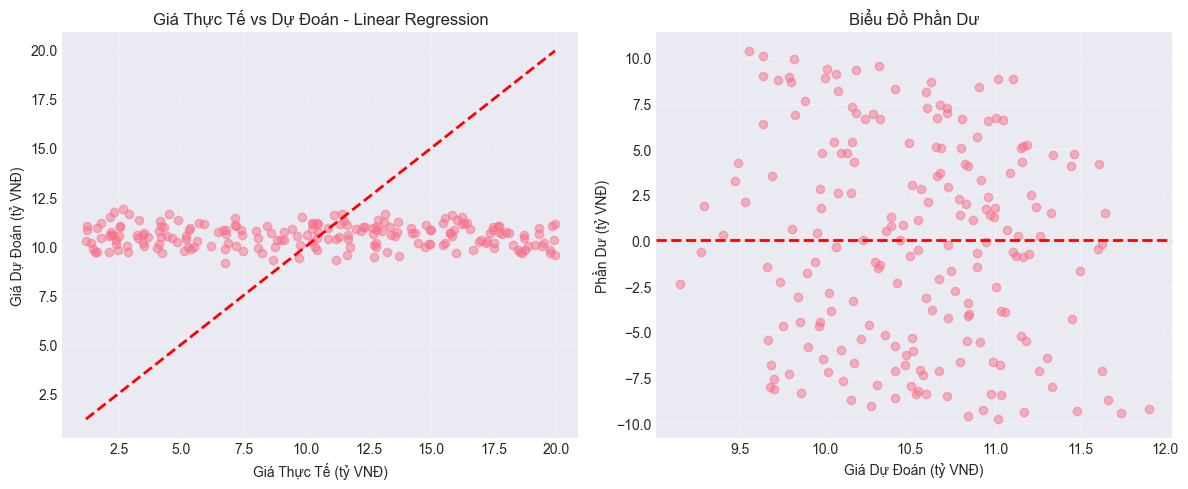

In [12]:
# Thực hiện dự đoán trên tập kiểm tra
y_pred = model_trainer.predict(X_test)

# Vẽ biểu đồ so sánh giá thực tế và dự đoán
plt.figure(figsize=(12, 5))

# Biểu đồ phân tán
plt.subplot(1, 2, 1)
plt.scatter(y_test / 1e9, y_pred / 1e9, alpha=0.5)
plt.plot([y_test.min() / 1e9, y_test.max() / 1e9], 
         [y_test.min() / 1e9, y_test.max() / 1e9], 
         'r--', lw=2)
plt.xlabel('Giá Thực Tế (tỷ VNĐ)')
plt.ylabel('Giá Dự Đoán (tỷ VNĐ)')
plt.title(f'Giá Thực Tế vs Dự Đoán - {best_model_name}')
plt.grid(True, alpha=0.3)

# Biểu đồ phần dư
plt.subplot(1, 2, 2)
residuals = (y_test - y_pred) / 1e9
plt.scatter(y_pred / 1e9, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Giá Dự Đoán (tỷ VNĐ)')
plt.ylabel('Phần Dư (tỷ VNĐ)')
plt.title('Biểu Đồ Phần Dư')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11.5. Workflow Thực Nghiệm Chi Tiết

Trong phần này, chúng ta sẽ thực hiện workflow thực nghiệm hoàn chỉnh:
1. Sử dụng mô hình tốt nhất để dự đoán giá trên tập test
2. So sánh giá dự đoán với giá thực tế
3. Phân tích kết quả chi tiết

### Bước 1: Xác định mô hình tốt nhất và dự đoán trên tập test

In [13]:
# Lấy mô hình tốt nhất
best_model_name = model_trainer.best_model_name
best_model = model_trainer.best_model

print("="*70)
print("THỰC NGHIỆM VỚI MÔ HÌNH TỐT NHẤT")
print("="*70)
print(f"\n🏆 Mô hình được chọn: {best_model_name}")
print(f"📊 Số mẫu test: {len(X_test)}")
print(f"📋 Số đặc trưng: {X_test.shape[1]}")

# Dự đoán giá trên tập test
print("\n⚙️  Đang thực hiện dự đoán trên tập test...")
y_pred_test = model_trainer.predict(X_test)

print("✓ Hoàn thành dự đoán!")

THỰC NGHIỆM VỚI MÔ HÌNH TỐT NHẤT

🏆 Mô hình được chọn: Linear Regression
📊 Số mẫu test: 200
📋 Số đặc trưng: 10

⚙️  Đang thực hiện dự đoán trên tập test...
✓ Hoàn thành dự đoán!


### Bước 2: So sánh giá dự đoán với giá thực tế

In [14]:
# Tạo DataFrame để so sánh
comparison_df = pd.DataFrame({
    'Giá Thực Tế (VNĐ)': y_test.values,
    'Giá Dự Đoán (VNĐ)': y_pred_test,
    'Giá Thực Tế (tỷ)': y_test.values / 1e9,
    'Giá Dự Đoán (tỷ)': y_pred_test / 1e9,
    'Sai Số (VNĐ)': y_test.values - y_pred_test,
    'Sai Số (tỷ)': (y_test.values - y_pred_test) / 1e9,
    'Sai Số (%)': np.abs((y_test.values - y_pred_test) / y_test.values * 100)
})

print("\n" + "="*70)
print("SO SÁNH GIÁ DỰ ĐOÁN VỚI GIÁ THỰC TÊ")
print("="*70)
print(f"\n📊 Hiển thị 20 mẫu đầu tiên:\n")
print(comparison_df.head(20).to_string(index=True))

# Thống kê tổng quan
print("\n" + "="*70)
print("THỐNG KÊ SAI SỐ")
print("="*70)
print(f"\nSai số trung bình: {comparison_df['Sai Số (tỷ)'].mean():.3f} tỷ VNĐ")
print(f"Sai số tuyệt đối trung bình: {comparison_df['Sai Số (tỷ)'].abs().mean():.3f} tỷ VNĐ")
print(f"Sai số phần trăm trung bình: {comparison_df['Sai Số (%)'].mean():.2f}%")
print(f"Sai số tối thiểu: {comparison_df['Sai Số (tỷ)'].min():.3f} tỷ VNĐ")
print(f"Sai số tối đa: {comparison_df['Sai Số (tỷ)'].max():.3f} tỷ VNĐ")
print(f"Độ lệch chuẩn sai số: {comparison_df['Sai Số (tỷ)'].std():.3f} tỷ VNĐ")


SO SÁNH GIÁ DỰ ĐOÁN VỚI GIÁ THỰC TÊ

📊 Hiển thị 20 mẫu đầu tiên:

    Giá Thực Tế (VNĐ)  Giá Dự Đoán (VNĐ)  Giá Thực Tế (tỷ)  Giá Dự Đoán (tỷ)  Sai Số (VNĐ)  Sai Số (tỷ)  Sai Số (%)
0        1.476244e+10       9.980842e+09         14.762438          9.980842  4.781596e+09     4.781596   32.390288
1        1.354575e+10       1.050778e+10         13.545752         10.507781  3.037970e+09     3.037970   22.427477
2        1.397954e+09       1.014955e+10          1.397954         10.149546 -8.751592e+09    -8.751592  626.028488
3        9.095584e+09       1.074051e+10          9.095584         10.740509 -1.644925e+09    -1.644925   18.084871
4        7.167131e+09       1.145025e+10          7.167131         11.450252 -4.283121e+09    -4.283121   59.760611
5        5.088836e+09       9.748464e+09          5.088836          9.748464 -4.659628e+09    -4.659628   91.565708
6        1.144106e+10       1.162702e+10         11.441061         11.627021 -1.859599e+08    -0.185960    1.625373
7    

### Bước 3: Trực quan hóa kết quả so sánh

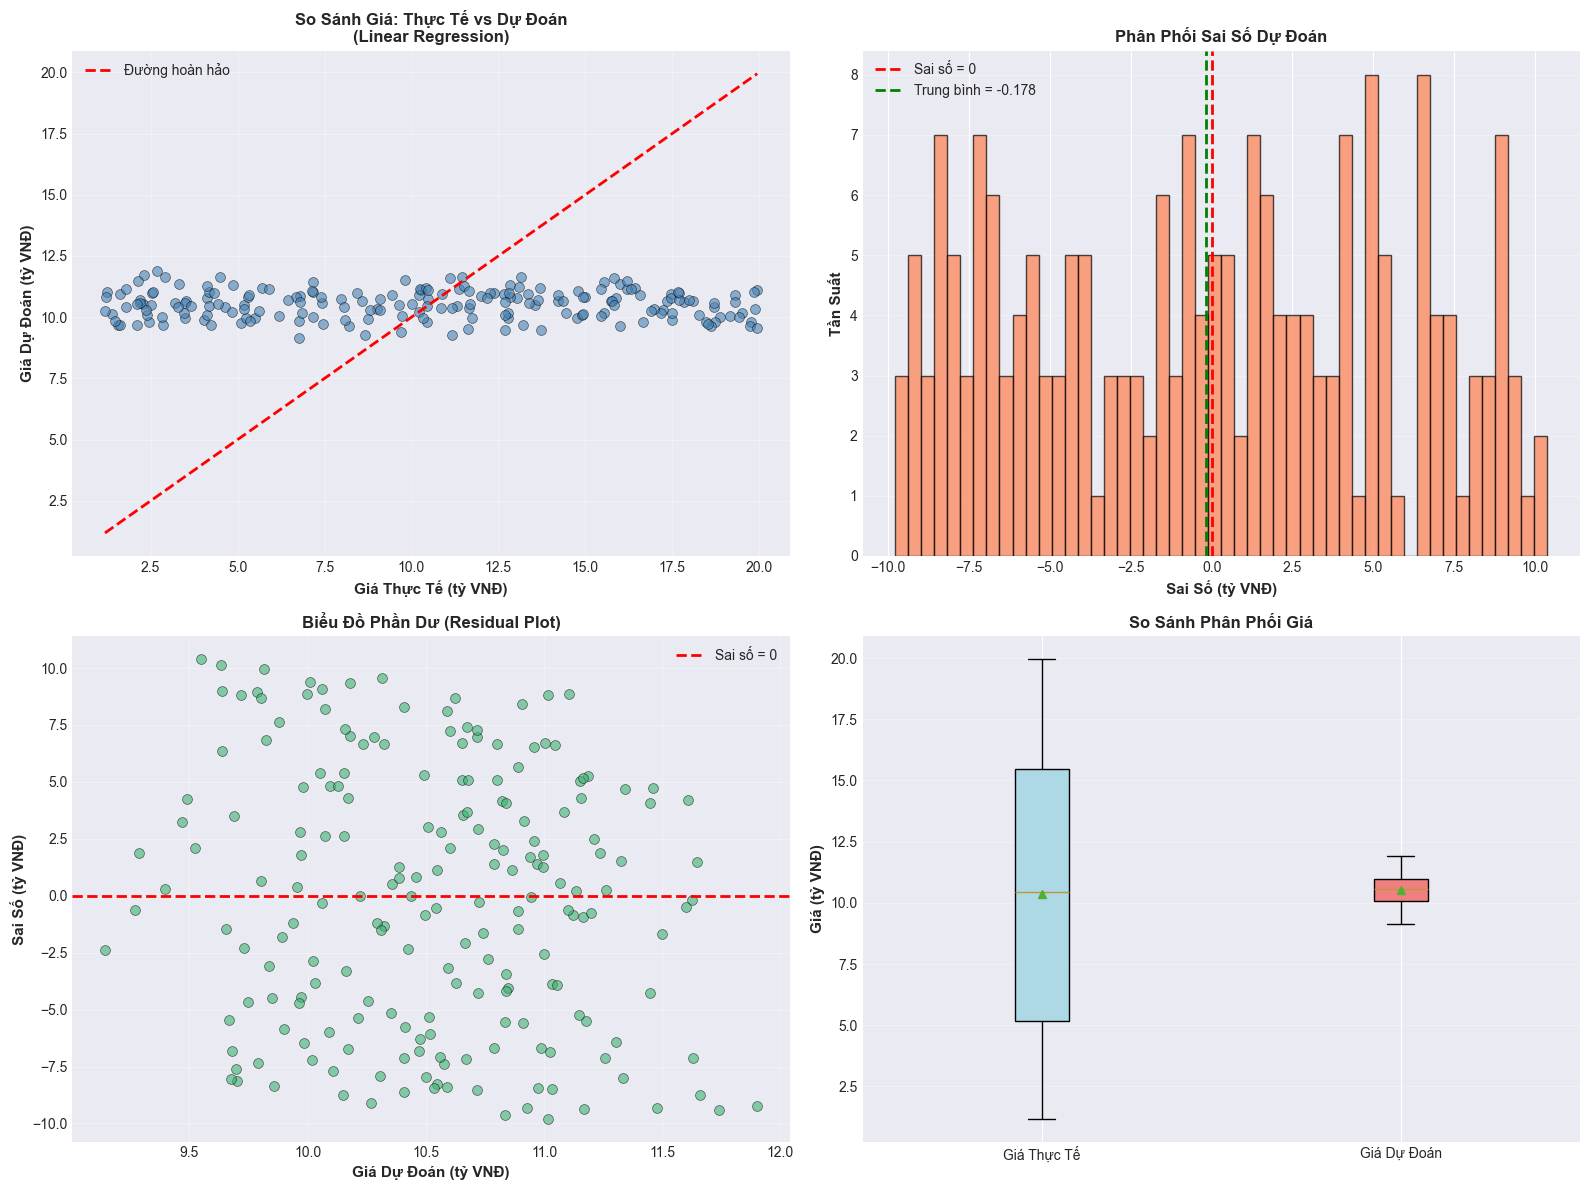

In [15]:
# Trực quan hóa so sánh
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot: Giá thực tế vs Giá dự đoán
axes[0, 0].scatter(comparison_df['Giá Thực Tế (tỷ)'], 
                   comparison_df['Giá Dự Đoán (tỷ)'], 
                   alpha=0.6, s=50, color='steelblue', edgecolor='black', linewidth=0.5)
axes[0, 0].plot([comparison_df['Giá Thực Tế (tỷ)'].min(), comparison_df['Giá Thực Tế (tỷ)'].max()],
                [comparison_df['Giá Thực Tế (tỷ)'].min(), comparison_df['Giá Thực Tế (tỷ)'].max()],
                'r--', lw=2, label='Đường hoàn hảo')
axes[0, 0].set_xlabel('Giá Thực Tế (tỷ VNĐ)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Giá Dự Đoán (tỷ VNĐ)', fontsize=11, fontweight='bold')
axes[0, 0].set_title(f'So Sánh Giá: Thực Tế vs Dự Đoán\n({best_model_name})', 
                     fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram: Phân phối sai số
axes[0, 1].hist(comparison_df['Sai Số (tỷ)'], bins=50, 
                color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', lw=2, label='Sai số = 0')
axes[0, 1].axvline(x=comparison_df['Sai Số (tỷ)'].mean(), 
                   color='green', linestyle='--', lw=2, label=f'Trung bình = {comparison_df["Sai Số (tỷ)"].mean():.3f}')
axes[0, 1].set_xlabel('Sai Số (tỷ VNĐ)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Tần Suất', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Phân Phối Sai Số Dự Đoán', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Residual plot: Sai số theo giá dự đoán
axes[1, 0].scatter(comparison_df['Giá Dự Đoán (tỷ)'], 
                   comparison_df['Sai Số (tỷ)'], 
                   alpha=0.6, s=50, color='mediumseagreen', edgecolor='black', linewidth=0.5)
axes[1, 0].axhline(y=0, color='red', linestyle='--', lw=2, label='Sai số = 0')
axes[1, 0].set_xlabel('Giá Dự Đoán (tỷ VNĐ)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Sai Số (tỷ VNĐ)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Biểu Đồ Phần Dư (Residual Plot)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot: So sánh phân phối
data_for_box = [comparison_df['Giá Thực Tế (tỷ)'], comparison_df['Giá Dự Đoán (tỷ)']]
bp = axes[1, 1].boxplot(data_for_box, labels=['Giá Thực Tế', 'Giá Dự Đoán'],
                        patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1, 1].set_ylabel('Giá (tỷ VNĐ)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('So Sánh Phân Phối Giá', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Bước 4: Đánh giá hiệu suất trên tập test

In [16]:
# ============================================================================
# ĐÁNH GIÁ CUỐI CÙNG VỚI CÁC METRICS
# ============================================================================
# Tính các metrics trên tập test để đánh giá hiệu suất thực tế của model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----------------------------------------------------------------------------
# METRIC 1: MSE (Mean Squared Error) - Trung bình bình phương sai số
# Công thức: MSE = (1/n) × Σ(yᵢ - ŷᵢ)²
# Đơn vị: VNĐ² (bình phương của đơn vị target)
# Range: [0, ∞), càng nhỏ càng tốt
# Đặc điểm: Penalize lỗi lớn nhiều hơn (do bình phương)
# ----------------------------------------------------------------------------
mse = mean_squared_error(y_test, y_pred_test)

# ----------------------------------------------------------------------------
# METRIC 2: RMSE (Root Mean Squared Error) - Căn MSE
# Công thức: RMSE = √MSE = √[(1/n) × Σ(yᵢ - ŷᵢ)²]
# Đơn vị: VNĐ (cùng đơn vị với target, dễ interpret)
# Range: [0, ∞), càng nhỏ càng tốt
# Ý nghĩa: Sai số trung bình, nhấn mạnh outliers
# Ví dụ: RMSE = 1 tỷ → Trung bình sai lệch ~1 tỷ VNĐ
# ----------------------------------------------------------------------------
rmse = np.sqrt(mse)

# ----------------------------------------------------------------------------
# METRIC 3: MAE (Mean Absolute Error) - Trung bình sai số tuyệt đối
# Công thức: MAE = (1/n) × Σ|yᵢ - ŷᵢ|
# Đơn vị: VNĐ (cùng đơn vị với target)
# Range: [0, ∞), càng nhỏ càng tốt
# Đặc điểm: Treat tất cả errors như nhau (không penalize outliers)
# So sánh: MAE < RMSE (always), nếu chênh lệch lớn → có nhiều outliers
# ----------------------------------------------------------------------------
mae = mean_absolute_error(y_test, y_pred_test)

# ----------------------------------------------------------------------------
# METRIC 4: R² Score (Coefficient of Determination) - Hệ số xác định
# Công thức: R² = 1 - (SS_res / SS_tot)
# Trong đó:
#   - SS_res = Σ(yᵢ - ŷᵢ)² (residual sum of squares - lỗi của model)
#   - SS_tot = Σ(yᵢ - ȳ)² (total sum of squares - variance của data)
# 
# Range: (-∞, 1]
# Ý nghĩa: Tỷ lệ variance của target được model giải thích được
# 
# INTERPRETATION:
#   R² = 1.0  → Perfect predictions (model giải thích 100% variance)
#   R² = 0.9  → Model giải thích 90% variance (rất tốt)
#   R² = 0.5  → Model giải thích 50% variance (trung bình)
#   R² = 0.0  → Model không tốt hơn baseline (dự đoán bằng mean)
#   R² < 0.0  → Model tệ hơn baseline (rất tệ!)
#
# Ví dụ: R² = 0.85 nghĩa là model capture được 85% variance trong giá nhà
# ----------------------------------------------------------------------------
r2 = r2_score(y_test, y_pred_test)

# ----------------------------------------------------------------------------
# METRIC 5: MAPE (Mean Absolute Percentage Error) - Sai số % trung bình
# Công thức: MAPE = (100/n) × Σ|（yᵢ - ŷᵢ）/yᵢ|
# Đơn vị: % (percentage)
# Range: [0, ∞), càng nhỏ càng tốt
# 
# ƯU ĐIỂM:
# - Scale-independent: Có thể compare across different scales
# - Dễ hiểu với business stakeholders (sai 10% dễ hiểu hơn sai 1 tỷ VNĐ)
# 
# NHƯỢC ĐIỂM:
# - Undefined khi yᵢ = 0
# - Asymmetric: Penalize underestimate nhiều hơn overestimate
#   Ví dụ: Actual=100, Predict=90 → Error=10%
#          Actual=100, Predict=110 → Error=10%
#   Nhưng: Actual=100, Predict=50 → Error=50%
#          Actual=100, Predict=150 → Error=50% (nhưng absolute diff khác!)
# ----------------------------------------------------------------------------
mape = np.mean(np.abs((y_test.values - y_pred_test) / y_test.values)) * 100

print("\n" + "="*70)
print(f"KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG - {best_model_name.upper()}")
print("="*70)
print("\n📈 Các chỉ số hiệu suất trên tập TEST:\n")
print(f"  • R² Score:                {r2:.4f}  (>0.7 là tốt, >0.8 là rất tốt)")
print(f"  • Mean Squared Error:      {mse:,.0f} VNĐ²")
print(f"  • Root Mean Squared Error: {rmse/1e9:.4f} tỷ VNĐ ({rmse:,.0f} VNĐ)")
print(f"  • Mean Absolute Error:     {mae/1e9:.4f} tỷ VNĐ ({mae:,.0f} VNĐ)")
print(f"  • Mean Absolute % Error:   {mape:.2f}%  (<10% là tốt, <20% là acceptable)")

# Phân loại độ chính xác
print("\n" + "="*70)
print("PHÂN LOẠI ĐỘ CHÍNH XÁC DỰ ĐOÁN")
print("="*70)

# Đếm số predictions theo độ chính xác
accurate = len(comparison_df[comparison_df['Sai Số (%)'] <= 10])
moderate = len(comparison_df[(comparison_df['Sai Số (%)'] > 10) & (comparison_df['Sai Số (%)'] <= 20)])
poor = len(comparison_df[comparison_df['Sai Số (%)'] > 20])

total = len(comparison_df)

print(f"\n✓ Dự đoán chính xác (sai số ≤10%):    {accurate:4d} mẫu ({accurate/total*100:5.1f}%)")
print(f"~ Dự đoán trung bình (10% < sai số ≤20%): {moderate:4d} mẫu ({moderate/total*100:5.1f}%)")
print(f"✗ Dự đoán kém (sai số >20%):          {poor:4d} mẫu ({poor/total*100:5.1f}%)")

print("\n💡 INTERPRETATION GUIDE:")
print("  • MAE vs RMSE: Nếu RMSE >> MAE → Có nhiều outliers (predictions sai lệch lớn)")
print("  • R² cao nhưng MAE/RMSE lớn → Model fit tốt nhưng scale lớn")
print("  • MAPE thấp → Predictions reliable cho business decisions")

print("\n" + "="*70)
print("✓ HOÀN THÀNH WORKFLOW THỰC NGHIỆM!")
print("="*70)


KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG - LINEAR REGRESSION

📈 Các chỉ số hiệu suất trên tập TEST:

  • R² Score:                -0.0178  (>0.7 là tốt, >0.8 là rất tốt)
  • Mean Squared Error:      32,318,412,422,917,824,512 VNĐ²
  • Root Mean Squared Error: 5.6849 tỷ VNĐ (5,684,928,533 VNĐ)
  • Mean Absolute Error:     4.8776 tỷ VNĐ (4,877,601,221 VNĐ)
  • Mean Absolute % Error:   102.30%  (<10% là tốt, <20% là acceptable)

PHÂN LOẠI ĐỘ CHÍNH XÁC DỰ ĐOÁN

✓ Dự đoán chính xác (sai số ≤10%):      26 mẫu ( 13.0%)
~ Dự đoán trung bình (10% < sai số ≤20%):   25 mẫu ( 12.5%)
✗ Dự đoán kém (sai số >20%):           149 mẫu ( 74.5%)

💡 INTERPRETATION GUIDE:
  • MAE vs RMSE: Nếu RMSE >> MAE → Có nhiều outliers (predictions sai lệch lớn)
  • R² cao nhưng MAE/RMSE lớn → Model fit tốt nhưng scale lớn
  • MAPE thấp → Predictions reliable cho business decisions

✓ HOÀN THÀNH WORKFLOW THỰC NGHIỆM!


## 12. Thực Hiện Dự Đoán Mẫu

In [17]:
# Tạo dữ liệu mẫu đầu vào
sample_input = utils.create_sample_input(
    district='Ba Đình',
    property_type='Nhà riêng',
    area=100.0,
    floors=3,
    bedrooms=3,
    length=10.0,
    width=10.0
)

print("Dữ Liệu Đầu Vào Mẫu:")
for key, value in sample_input.items():
    print(f"  {key}: {value}")

# Lưu ý: Để thực hiện dự đoán thực tế, cần mã hóa dữ liệu đầu vào
print("\n⚠️ Để thực hiện dự đoán thực tế, dữ liệu đầu vào cần được mã hóa sử dụng")
print("cùng bộ mã hóa đã dùng khi huấn luyện. Xem ứng dụng Streamlit để biết chi tiết.")

Dữ Liệu Đầu Vào Mẫu:
  Quận: Ba Đình
  Loại hình nhà ở: Nhà riêng
  Diện tích: 100.0
  Số tầng: 3
  Số phòng ngủ: 3
  Dài: 10.0
  Rộng: 10.0
  Giấy tờ pháp lý: Sổ đỏ/ Sổ hồng

⚠️ Để thực hiện dự đoán thực tế, dữ liệu đầu vào cần được mã hóa sử dụng
cùng bộ mã hóa đã dùng khi huấn luyện. Xem ứng dụng Streamlit để biết chi tiết.


## 13. Lưu Mô Hình Tốt Nhất

In [18]:
# Lưu mô hình tốt nhất
model_path = '../models/best_housing_model.pkl'

model_trainer.save_model(filepath=model_path)

print(f"\n✓ Đã lưu mô hình tốt nhất ({best_model_name}) thành công!")
print(f"Đường dẫn mô hình: {model_path}")

✓ Model saved to: ../models/best_housing_model.pkl

✓ Đã lưu mô hình tốt nhất (Linear Regression) thành công!
Đường dẫn mô hình: ../models/best_housing_model.pkl


## 14. Kiểm Tra Tải Mô Hình Đã Lưu

In [19]:
# Tạo bộ huấn luyện mới và tải mô hình đã lưu
test_trainer = HousingPriceModel()
loaded_model = test_trainer.load_model(model_path)

# Thực hiện dự đoán thử nghiệm
test_pred = test_trainer.predict(X_test[:5])

print("\nDự Đoán Thử Nghiệm (5 mẫu đầu tiên):")
for i, (actual, predicted) in enumerate(zip(y_test[:5], test_pred)):
    print(f"Mẫu {i+1}:")
    print(f"  Thực tế:   {actual/1e9:.2f} tỷ VNĐ")
    print(f"  Dự đoán:   {predicted/1e9:.2f} tỷ VNĐ")
    print(f"  Sai số:    {abs(actual - predicted)/1e9:.2f} tỷ VNĐ\n")

✓ Model loaded from: ../models/best_housing_model.pkl
  Model: Linear Regression
  Features: 10

Dự Đoán Thử Nghiệm (5 mẫu đầu tiên):
Mẫu 1:
  Thực tế:   14.76 tỷ VNĐ
  Dự đoán:   9.98 tỷ VNĐ
  Sai số:    4.78 tỷ VNĐ

Mẫu 2:
  Thực tế:   13.55 tỷ VNĐ
  Dự đoán:   10.51 tỷ VNĐ
  Sai số:    3.04 tỷ VNĐ

Mẫu 3:
  Thực tế:   1.40 tỷ VNĐ
  Dự đoán:   10.15 tỷ VNĐ
  Sai số:    8.75 tỷ VNĐ

Mẫu 4:
  Thực tế:   9.10 tỷ VNĐ
  Dự đoán:   10.74 tỷ VNĐ
  Sai số:    1.64 tỷ VNĐ

Mẫu 5:
  Thực tế:   7.17 tỷ VNĐ
  Dự đoán:   11.45 tỷ VNĐ
  Sai số:    4.28 tỷ VNĐ



## Tổng Kết

Trong notebook này, chúng ta đã:
1. ✓ Tải dữ liệu đã xử lý
2. ✓ Thực hiện kỹ thuật đặc trưng
3. ✓ Huấn luyện 4 mô hình ML khác nhau
4. ✓ So sánh hiệu suất mô hình
5. ✓ Thực hiện kiểm chứng chéo
6. ✓ Phân tích độ quan trọng của đặc trưng
7. ✓ Lưu mô hình tốt nhất

**Mô Hình Tốt Nhất**: {best_model_name}

**Bước Tiếp Theo**: Sử dụng ứng dụng Streamlit (`streamlit run app/streamlit_app.py`) để dự đoán tương tác!